In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

import findspark
findspark.init()

from pyspark.mllib.clustering import KMeans
from pyspark.sql import SQLContext, Row, SparkSession
from pyspark import SparkContext
from pyspark.conf import SparkConf

Populating the interactive namespace from numpy and matplotlib


In [2]:
sc = SparkContext()
spark = SparkSession.builder.config(conf=SparkConf()).appName("Clustering").getOrCreate()
feature_names = ['sepal length (cm)',
                'sepal width (cm)',
                'petal length (cm)',
                'petal width (cm)']
target_names = ['setosa', 'versicolor', 'virginica']
target_indices = sc.parallelize(target_names).zipWithIndex()
print target_indices.take(3)
names = target_indices.map(lambda row: Row(type=row[0], index=row[1]))
names_df = spark.createDataFrame(names).cache()

[('setosa', 0), ('versicolor', 1), ('virginica', 2)]


In [3]:
random_points = spark.sparkContext.textFile("/home/edupy/Desktop/Datasets/iris.csv")
random_points.cache()
random_points.takeSample(True, 5)

[u'7.1,3.0,5.9,2.1,virginica',
 u'6.4,3.2,5.3,2.3,virginica',
 u'4.8,3.1,1.6,0.2,setosa',
 u'6.9,3.1,4.9,1.5,versicolor',
 u'5.7,2.8,4.5,1.3,versicolor']

In [4]:
data_rdd = random_points.map(lambda row: row.split(",")).map(lambda row: Row(
        sepal_length=float(row[0]),
        sepal_width=float(row[1]),
        petal_length=float(row[2]),
        petal_width=float(row[3]),
        type=row[4]))
data_df = spark.createDataFrame(data_rdd).cache()
data = data_rdd.map(lambda row: np.array([float(row[0]), float(row[1]), float(row[2]), float(row[3])]))
data.take(5)


[array([ 1.4,  0.2,  5.1,  3.5]),
 array([ 1.4,  0.2,  4.9,  3. ]),
 array([ 1.3,  0.2,  4.7,  3.2]),
 array([ 1.5,  0.2,  4.6,  3.1]),
 array([ 1.4,  0.2,  5. ,  3.6])]

In [5]:
centers = 3
model = KMeans.train(data, centers)

In [6]:
for i , center in enumerate(model.centers):
    print i, center

0 [ 1.75416667  0.32916667  4.74166667  2.95416667]
1 [ 4.97395833  1.703125    6.31458333  2.89583333]
2 [ 1.47333333  0.28        5.21666667  3.64      ]


In [7]:
m2 = sc.broadcast(model)
labels = data.map(lambda row: m2.value.predict(row)).collect()
X = data_df.select('petal_width').collect()
Y = data_df.select('sepal_length').collect()
Z = data_df.select('petal_length').collect()

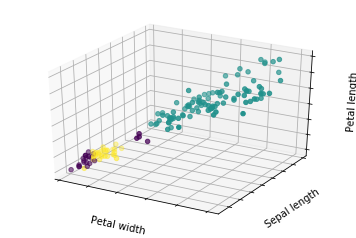

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c=labels)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

In [9]:
ind = data_df.select('type').join(names_df, data_df.type == names_df.type).select('index').collect()
ind[:5]

[Row(index=0), Row(index=0), Row(index=0), Row(index=0), Row(index=0)]

Row(avg(petal_width)=0.2439999999999999, avg(sepal_length)=5.005999999999999, avg(petal_length)=1.464) setosa
Row(avg(petal_width)=1.3259999999999998, avg(sepal_length)=5.936, avg(petal_length)=4.26) versicolor
Row(avg(petal_width)=2.026, avg(sepal_length)=6.587999999999998, avg(petal_length)=5.552) virginica


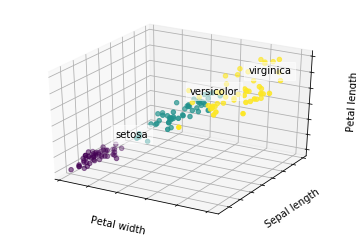

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_df.select('petal_width').collect(),
           data_df.select('sepal_length').collect(),
           data_df.select('petal_length').collect(), c=ind)
for name, label in target_indices.collect():
    X_mean = data_df.filter(data_df.type == name).agg(
        {'petal_width': 'avg', 'sepal_length': 'avg', 'petal_length': 'avg'}).collect()[0]
    print X_mean, name
    ax.text3D(X_mean[0], X_mean[1] + 1.5, X_mean[2], name,
             horizontalalignment='center',
             bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')